# Exercise 12.3

Learn a deep neural network autoencoder to build a linear model for flow  around a cylinder. Use high-fidelity flow around a cylinder data to learn a coordinate  (autoencoder) transformation to an (r = 3)-dimensional subspace where the dynamics  is linear and a Koopman operator can be constructed. In the new linear coordinates,  compute the eigenvalues and eigenvectors of the latent state representation. Use the model  to forecast the future state and compare with the high-fidelity simulations.  Exercise 12.4 Learn a deep neural network autoencoder to build a parsimonious,

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import layers, losses , optimizers

Import the dataset describing the motion of a flid across a cylinder, already used in exercise 3.X01.

In [2]:
cylinder_data = scipy.io.loadmat("../DATA/CYLINDER_ALL.mat")

m = cylinder_data['m'].squeeze()
n = cylinder_data['n'].squeeze()
X = cylinder_data['VORTALL']
print(X.shape)

(89351, 151)


Prepare the dataset to train the autoencoder; if we call $T$ the number of snapshots, ```input_dataset``` contains the first $( 0 , ... T-2 )$ snaphots and ```output_datase``` contains the last $( 1 , ... T-1 )$ snapshots. The snapshots are then shuffled.

In [3]:
input_d = X[ : , :-1 ]
output_d = X[ : , 1: ]

# Random shuffle.
idx = np.random.choice( input_d.shape[1] , input_d.shape[1]  , replace = False )
input_dataset = input_d[ : , idx ]
output_dataset = output_d[ : , idx ]

Define the deep autoencoder, which is composed of three main structures:
1) **The Encoder:** it is a sequential network composed of six layers, with hidden units which goes from nxm to 3. As its name suggests the encoder encodes one snapshot, $x_k$, in a latent space with dimnsion r = 3:

$$y_k=\phi(x_k)$$

2) **The Koopeman operator:** two sequential layers with linear activation function and no biases lay in the middle of the deep autoencoder. They encode a Koopeman operator, i.e. a linear map which describes the dynamic between latent state $k$ and latent state $k+1$: 

$$K_{\Delta t}y_k=y_{k+1}$$

3) **The decoder:** the decoder is equivalent to the encoder, but reversed. It maps the latent state representation of the dynamic system, $y_{k+1}$, back to the full starting dimensionality 

$$x_{k+1}=\phi^{-1}(y_{k+1})$$

A nice picture describing this architecture can be found at page 304 of the book, second edition.

In [4]:
class Autoencoder( Model ):
  def __init__( self , input_dim , latent_dim , output_dim ):
    
    super( Autoencoder , self ).__init__()
    self.latent_dim = latent_dim   
    
    # Encoder.
    self.encoder = tf.keras.Sequential([

    layers.Dense( int( input_dim / 100 ) , activation = "selu" , input_shape=( input_dim , )),
    layers.Dense( int( input_dim / 250 ) , activation = "selu" ),
    layers.Dense( int( input_dim / 500 ) , activation = "selu" ),    
    layers.Dense( int( input_dim / 750 ) , activation = "selu" ),
    layers.Dense( int( input_dim / 1000 ) , activation = "selu" ),
    layers.Dense( int( input_dim / 1250 ) , activation = "selu" ),
    layers.Dense( latent_dim , activation = "selu" ),
        
    ])
    
    # Koopeman operator.
    self.K = tf.keras.Sequential([ 
        
    layers.Dense( latent_dim , activation = "linear" , use_bias=False ),
    layers.Dense( latent_dim , activation = "linear" , use_bias=False )
        
    ])
    
    # Decoder.
    self.decoder = tf.keras.Sequential([
        
    layers.Dense( latent_dim , activation = "selu" ),
    layers.Dense( int( input_dim / 1250 ) , activation = "selu" ),
    layers.Dense( int( input_dim / 1000 ) , activation = "selu" ),
    layers.Dense( int( input_dim / 750 ) , activation = "selu" ),
    layers.Dense( int( input_dim / 500 ) , activation = "selu" ),
    layers.Dense( int( input_dim / 250 ) , activation = "selu" ),
    layers.Dense( int( input_dim / 100 ) , activation = "selu"  ),
    layers.Dense( output_dim , activation = "linear" ),
        
    ])

  def call( self , x ):
    
    encoded = self.encoder( x )
    K = self.K( encoded )
    decoded = self.decoder( K )
    
    return decoded

Compile and fit the model.

In [5]:
input_dim = input_d.shape[0]
output_dim = output_d.shape[0]
latent_dim = 3
autoencoder = Autoencoder( input_dim , latent_dim , output_dim )
autoencoder.compile( optimizer = optimizers.Adam( learning_rate = 0.001 ) , loss = losses.MeanSquaredError() )

from keras.callbacks import EarlyStopping
callback = EarlyStopping( monitor='loss' , patience = 50 , min_delta = 1e-10)

H = autoencoder.fit( input_dataset.T , output_dataset.T , epochs = 300, batch_size = 200 , shuffle = True , callbacks=[callback] , verbose = 0 )

Extract the Koopeman operator, compute its eigenvalues and eigenvectors.

In [6]:
K = autoencoder.K.layers[0].get_weights()[0]
Lambdas , Phi = np.linalg.eig( K )

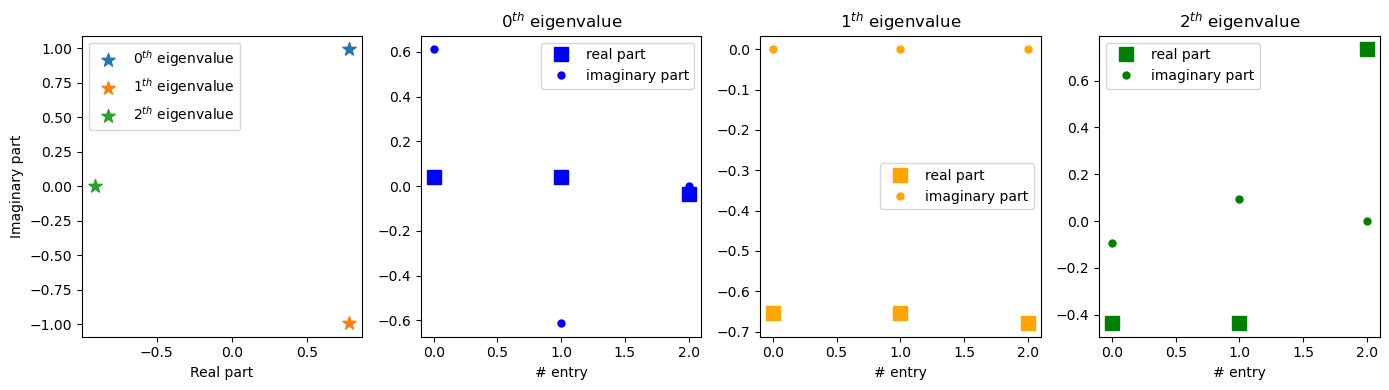

In [7]:
fig , ax = plt.subplots( 1 , 4 , figsize = ( 14 , 4 ) )
for ii , Lambda in enumerate( Lambdas ):
    ax[0].scatter( np.real(Lambda) , np.imag(Lambda) , marker = "*" , s = 100 , label = str(ii)+"$^{th}$ eigenvalue" )
ax[0].set_xlabel("Real part")
ax[0].set_ylabel("Imaginary part")
ax[0].legend()
ii = 0
for phi , c in zip( Phi , [ "blue" , "orange" , "green" ] ):
    ax[ ii + 1 ].plot( np.real( phi ) , marker = "s" , linestyle = " " , color = c , markersize = 10 , label = "real part" )
    ax[ ii + 1 ].plot( np.imag( phi ) , marker = "o" , linestyle = " " , color = c , markersize = 5 , label = "imaginary part" )
    ax[ ii + 1 ].set_title( str(ii) + "$^{th}$ eigenvalue" )
    ax[ ii + 1 ].set_xlabel("# entry")
    ax[ ii + 1 ].legend()
    ii = ii + 1
plt.tight_layout()

Make predictions using the autoencoder and compare with high fidelity simulations. The deep AE looks quite capable to recover the system dynamic throught the latent space. 

In [8]:
X_pred = autoencoder.predict( input_d.T )
X_pred = X_pred.T
X_pred = X_pred.reshape(( n , m , 150))

5/5 [==============================] - 1s 87ms/step


In [ ]:
from matplotlib.animation import FuncAnimation
import matplotlib as mpl
mpl.rcParams["figure.facecolor"] = "white"
from mpl_toolkits.axes_grid1 import make_axes_locatable
    
real_data = output_d.reshape(( n , m , 150))
predictions = X_pred
error = X_pred - output_d.reshape(( n , m , 150))

total_frames = predictions.shape[-1]

# First set up the figure, the axis, and the plot element we want to animate
fig, axes = plt.subplots( 1 , 3 , figsize = ( 10 , 7 ) , sharey = True )


labels = ['Simulation', 'Prediction', 'Error']
zz = [real_data,predictions,error]
images = []

for tt, label, z in zip( range( axes.shape[-1] ) , labels , zz ):
    vmin = np.min(z[ : , : , tt ])
    vmax = np.max(z[ : , : , tt ])
    p = axes[tt].imshow( z[ : , : , tt ] , cmap='RdBu_r', vmin = vmin , vmax = vmax )
    axes[tt].set_title( label )
    images.append( p )
    div = make_axes_locatable( axes[tt] )
    cax = div.append_axes('right', '5%', pad = 0.1 )
    fig.colorbar( p , cax = cax )
plt.tight_layout()


# animation function.  This is called sequentially
def animate(i, zz):
    for idx_im, (image, z) in enumerate( zip( images , zz ) ):
        image.set_array(z[ : , : , i ])


anim = FuncAnimation(fig, lambda i: animate(i, zz), frames=total_frames, interval=5)

video_name = 'AE_predictions.mp4'
anim.save(video_name, fps=total_frames/10, extra_args=['-vcodec', 'libx264'])
plt.close()

In [3]:
%%HTML
<iframe width="560" height="315" src="https://www.youtube.com/embed/WLxJbQU_K68" title="YouTube video player" frameborder="0" 
allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture; web-share" allowfullscreen></iframe>

You can fine the video at this link: [Autoencoder predictions](https://youtu.be/WLxJbQU_K68)